In [1]:
import tensorflow as tf   # pip install tensorflow-gpu
import cv2  # pip install opencv-python or pip install opencv-contrib-python (fullpackage)
import os
import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np # pip install numpy

In [22]:
img_array = cv2.imread("C:/Users/verya/Desktop/DS23/intro/data/chest_xray/train/normal/im-0115-0001.jpeg") 
# Kaggle (https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) training set

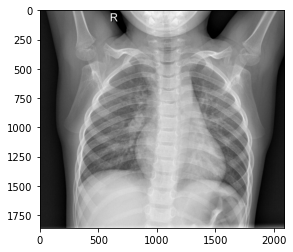

In [23]:
plt.imshow(img_array)

In [24]:
img_array.shape

(1858, 2090, 3)

In [25]:
print(img_array) # pixel colour 0 -> black, 255 -> white

[[[ 22  22  22]
  [ 24  24  24]
  [ 24  24  24]
  ...
  [ 96  96  96]
  [ 94  94  94]
  [ 93  93  93]]

 [[ 23  23  23]
  [ 24  24  24]
  [ 24  24  24]
  ...
  [ 97  97  97]
  [ 94  94  94]
  [ 92  92  92]]

 [[ 24  24  24]
  [ 24  24  24]
  [ 23  23  23]
  ...
  [ 99  99  99]
  [ 96  96  96]
  [ 94  94  94]]

 ...

 [[ 49  49  49]
  [ 50  50  50]
  [ 48  48  48]
  ...
  [119 119 119]
  [119 119 119]
  [119 119 119]]

 [[ 50  50  50]
  [ 52  52  52]
  [ 53  53  53]
  ...
  [123 123 123]
  [124 124 124]
  [123 123 123]]

 [[ 52  52  52]
  [ 53  53  53]
  [ 54  54  54]
  ...
  [129 129 129]
  [128 128 128]
  [127 127 127]]]


In [35]:
Datadirectory = "C:/Users/verya/Desktop/DS23/intro/data/chest_xray/train/" # training dataset

In [36]:
Classes = ["normal", "pneumonia"]  # List of classes -> normal, pneumonia

In [54]:
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

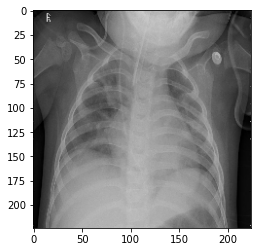

In [55]:
img_size = 224 # ImageNet resize -> 224 x 224  making bilinear to train them
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

# Bilder werden auf bilineare Dimension 224 x 224 geschnitten werden

In [56]:
new_array.shape

(224, 224, 3)

In [57]:
training_Data = [] # data

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) # normal, pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

In [58]:
create_training_Data()

In [59]:
print(len(training_Data)) # 5216 images

5216


In [60]:
temp = np.array(training_Data)

<ipython-input-60-b8d83967cc6f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(training_Data)


In [61]:
temp.shape

(5216, 2)

In [62]:
import random

random.shuffle(training_Data)

In [63]:
x = []  # data / feature
y = []  # label

for features, label in training_Data:
    x.append(features)
    y.append(label)
    
    
x = np.array(x).reshape(-1, img_size, img_size, 3) 
# convertung to 4 dimension, as much as resulting 4-dimensional tensor can then be used as input for deep learning 
# models that expect image data with such dimensions, such as convolutional neural networks (CNNs) commonly used for image classification tasks

In [64]:
x.shape # showing 4 dim

(5216, 224, 224, 3)

In [65]:
# normalize the data before deeplearning
x = x/255.0;
# Dividing by 255.0 is a common practice for image data with pixel values ranging from 0 to 255

In [66]:
type(y) # label

list

In [67]:
y[0]

1

In [68]:
y = np.array(y)

In [69]:
y.shape

(5216,)

In [70]:
# deep learning model for training - Transfer Learning: we take vorhandenes wissen and add some new layers to get a faster result 

import tensorflow as tf  # pytorch has also tensors, hence taking tensorflow as 1. naive implementation makes sense
from tensorflow import keras
from tensorflow.keras import layers

In [71]:
model = tf.keras.applications.MobileNetV2() # pre-trained model as example from slide Nr.24 / creates an instance of the MobileNetV2 model from the TensorFlow Keras applications module

In [72]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [73]:
# transfer learning - tuning, weights will start from last check point

base_input = model.layers[0].input  # cutting 1st layer from the end

In [74]:
base_output = model.layers[-2].output # adding 3 layers to the end: 1280 -> 128 -> 64 -> 2

In [75]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [77]:
final_output = layers.Dense(128)(base_output) # adding new layer after output of global pooling layer
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(2, activation = 'softmax')(final_output) # 2 classes, classification layers

In [78]:
final_output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>

In [79]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [80]:
new_model.summary() # 3 dense layers has been added

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [81]:
new_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [82]:
new_model.fit(x, y, epochs = 7) #tuned weights: start ca. 94% last 99.22% / 7 epochs as good as 30 / accuracy may vary, depends on last checkpoint

Epoch 1/7
163/163 [==============================] - 407s 2s/step - loss: 0.1046 - accuracy: 0.9576
Epoch 2/7
163/163 [==============================] - 414s 3s/step - loss: 0.0691 - accuracy: 0.9770
Epoch 3/7
163/163 [==============================] - 425s 3s/step - loss: 0.0550 - accuracy: 0.9818
Epoch 4/7
163/163 [==============================] - 369s 2s/step - loss: 0.0414 - accuracy: 0.9835
Epoch 5/7
163/163 [==============================] - 376s 2s/step - loss: 0.0255 - accuracy: 0.9916
Epoch 6/7
163/163 [==============================] - 376s 2s/step - loss: 0.0268 - accuracy: 0.9912
Epoch 7/7
163/163 [==============================] - 375s 2s/step - loss: 0.0333 - accuracy: 0.9883


In [132]:
new_model.save('Final_model.h5') # model will be saved

In [133]:
new_model = tf.keras.models.load_model('Final_model.h5')

In [134]:
newfoto = cv2.imread("C:/Users/verya/Desktop/DS23/intro/data/chest_xray/test/normal/im-0001-0001.jpeg")

In [135]:
newfoto.shape

(1317, 1857, 3)

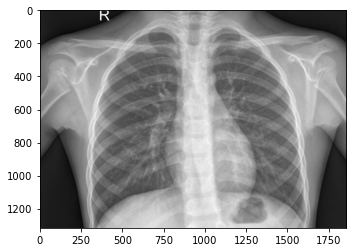

In [136]:
plt.imshow(newfoto)

In [137]:
final_image = cv2.resize(newfoto, (224, 224))  # resize to 224 x 224
final_image = np.expand_dims(final_image, axis = 0) # 4th dim
final_image = final_image/255.0

In [138]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 1s 611ms/step


In [139]:
Predictions[0] # for axis 0 with size 1; on that newfoto above we see healthy lungs

array([0.99720037, 0.00279959], dtype=float32)

In [141]:
newfoto2 = cv2.imread("C:/Users/verya/Desktop/DS23/intro/data/chest_xray/test/pneumonia/person20_virus_51.jpeg")

In [142]:
newfoto2.shape # same sized

(1208, 1320, 3)

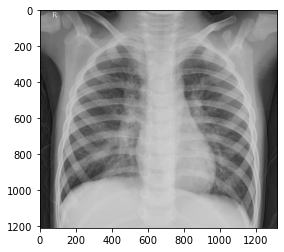

In [143]:
plt.imshow(newfoto2)

In [144]:
final_image2 = cv2.resize(newfoto2, (224, 224))
final_image2 = np.expand_dims(final_image2, axis = 0) # 4th dim
final_image2 = final_image2/255.0

In [145]:
Predictions = new_model.predict(final_image2)

1/1 [==============================] - 0s 36ms/step


In [149]:
Predictions[0] # for axis 0 with size 1; on that newfoto2 above we see damaged lungs

array([0.12915073, 0.87084925], dtype=float32)